In [1]:
from models.q_network import CardFeaturizer1
import torch as t
from game.utils import variable, moving_avg
import numpy as np
from game.game_utils import Card, cards_to_array
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from IPython import display
import pickle
from tqdm import tqdm
import os

# Load dataset

Load data

In [2]:
train_filenames = ['data/hand_eval/train/'+f for f in os.listdir('data/hand_eval/train/')]
test_filenames = ['data/hand_eval/test/'+f for f in os.listdir('data/hand_eval/test/')]

In [3]:
for filename in tqdm(train_filenames):
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                train_dataset[k] = v
        except:
            train_dataset = dataset_
for filename in tqdm(test_filenames):
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                test_dataset[k] = v
        except:
            test_dataset = dataset_


100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


In [4]:
len(train_dataset), len(test_dataset)

(1388908, 155987)

# Parse dataset

In [14]:
def clip(x):
    return x*(x>=1e-2)*(x<=.99) + .99*(x>.99) + .01*(x<.01)

frozenset({'2d', '6c', '9d', '7s'})): {'player1winprob': 0.15217391304347827, 'High Card': 0.5217391304347826, 'Pair': 0.391304347826087, 'Two Pair': 0.0, 'Three of a Kind': 0.0, 'Straight': 0.08695652173913043, 'Flush': 0.0, 'Full House': 0.0, 'Four of a Kind': 0.0, 'Straight Flush': 0.0, 'Royal Flush': 0.0}}
Time diff is 0.002004861831665039

In [15]:
def parse_dataset(dataset):
    x_hand = np.zeros((len(dataset), 13, 4))
    x_board = np.zeros((len(dataset), 3, 13, 4))
    y_hs = np.zeros((len(dataset), ))
    y_probas_combi = np.zeros((len(dataset), 9))

    for i, (cards_, probas) in enumerate(dataset.items()):
        # if there are only two cards and nothing on the board then the keys don't have the same format.....
        if isinstance(cards_, tuple):
            hand_, board_ = cards_
        else:
            hand_ = cards_
            board_ = None

        hand = []
        board = []

        for card_ in hand_:
            if card_[0] != 'T':
                try:
                    hand.append(Card(card_[0], card_[1]))
                except:
                    print(hand_, board_)
                    raise Exception
            else:
                hand.append(Card('10', card_[1]))

        if board_ is not None:
            for card_ in board_:
                if card_[0] != 'T':
                    board.append(Card(card_[0], card_[1]))
                else:
                    board.append(Card('10', card_[1]))

        x_hand[i] = cards_to_array(hand)
        x_board[i] = cards_to_array(board)
        hs = clip(probas['player1winprob'])
        y_hs[i] = np.log(hs/(1-hs))
        y_probas_combi[i][0] = probas['High Card']
        y_probas_combi[i][1] = probas['Pair']
        y_probas_combi[i][2] = probas['Two Pair']
        y_probas_combi[i][3] = probas['Three of a Kind']
        y_probas_combi[i][4] = probas['Straight']
        y_probas_combi[i][5] = probas['Flush']
        y_probas_combi[i][6] = probas['Full House']
        y_probas_combi[i][7] = probas['Four of a Kind']
        y_probas_combi[i][8] = probas['Straight Flush']
    return x_hand, x_board, y_hs, y_probas_combi


In [16]:
x_hand_train, x_board_train, y_hs_train, y_probas_combi_train = parse_dataset(train_dataset)
x_hand_test, x_board_test, y_hs_test, y_probas_combi_test = parse_dataset(test_dataset)

Scale data

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_hs_train = scaler.fit_transform(y_hs_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [18]:
y_hs_test = scaler.transform(y_hs_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


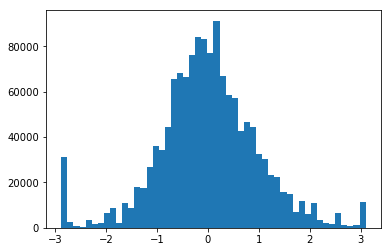

In [19]:
plt.hist(y_hs_train, bins=50)
plt.show()

In [43]:
count, bins, _ = plt.hist(y_hs_train, bins=50)

In [44]:
def inv_freq(x, count, bins):
    """
    Give a weight to each loss inversely proportional to their occurence frequency
    This way the model doesn't learn to just output the most common value
    """
    total = float(count.sum())
    for k in range(count.shape[0]-1):
        c, b0,b1 = float(count[k]),float(bins[k]),float(bins[k+1])
        try:
            weight += (total/c)*((x>=b0).float())*((x<b1).float())
        except:
            weight = (total/c)*((x>=b0).float())*((x<b1).float())
    return weight

# Train neural network

You may want to change the model here

In [44]:
f = CardFeaturizer1(50, 10)
print('#params: ', np.sum([np.prod(p.data.numpy().shape) for p in f.parameters()]))

#params:  70191


In [45]:
def clip(x):
    """Clip values below 1e-2 or above .99"""
    return x*(x>=1e-2).float()*(x<=.99).float() + .99*(x>.99).float() + .01*(x<.01).float()

# TRAINING LOOP WITH ONLY ONE OUTPUT (THE HAND STRENGTH)
You should use the class **CardFeaturizer1**

epoch 10
[0.17440537, 0.16374356, 0.19115505, 0.14741614, 0.17811672, 0.19092856, 0.23324645, 0.16845532, 0.18384816, 0.20703265]


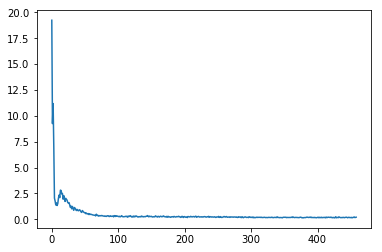

In [ ]:
lr = 1e-4  # 1e-4 for selu
batch_size = 64
EPOCHS = 50
optimizer = t.optim.Adam(f.parameters(), lr=lr, weight_decay=1e-3)
train_losses = []
test_losses = []
PLOT = 500


for _ in range(EPOCHS):
    print('epoch', _)
    # shuffle
    x_hand_train, x_board_train, y_hs_train = shuffle(x_hand_train, x_board_train, y_hs_train)
    
    # check if weights are NaN
    for p in f.parameters():
        if np.isnan(p.data.numpy()).sum()>0:
            raise ValueError('nan weights !')
    
    for i in range(0, len(train_dataset), batch_size):
        # check if BN var is NaN
#         check_bn_var_nan(f)
        
        # sample batch
        hand = variable(x_hand_train[i:i+batch_size])
        board = variable(x_board_train[i:i+batch_size])
        target = variable(y_hs_train[i:i+batch_size]).squeeze()
        if len(hand) != batch_size:
            break
        
        # init grad
        optimizer.zero_grad()
        
        # pred
        HS, flop_features, turn_features, river_features, cards_features = f.forward(hand, board)
        HS = clip(HS.squeeze())
        pred = t.log(HS/(1-HS))
        loss = (target - pred)**2  # target already has this format (scaled logit)
        loss = t.mean(loss)
        train_losses.append(loss.data.numpy()[0])
        
        loss.backward()
#         clip_gradients(f, 5)
        
        optimizer.step()
        
        if (i//batch_size) % PLOT == 0:
            display.clear_output(wait=True)
            print('epoch', _)
            
            # test loss on a random test sample
            x_hand_test, x_board_test, y_hs_test = shuffle(x_hand_test, x_board_test, y_hs_test)
            hand = variable(x_hand_test[:1000])
            board = variable(x_board_test[:1000])
            target = variable(y_hs_test[:1000]).squeeze()
            f.eval()
            HS, flop_features, turn_features, river_features, cards_features = f.forward(hand, board)
            HS = clip(HS.squeeze())
            f.train()
            pred = t.log(HS/(1-HS))
            loss = (target - pred)**2
            loss = t.mean(loss)      
            test_losses.append(loss.data.numpy()[0])
            
            # plot
            print(test_losses[-10:])
            plt.plot(test_losses)
            plt.show()
            train_losses_ = moving_avg(train_losses)
            print(train_losses_[-10:])
            plt.plot(train_losses_)
            plt.show()

# SAVE/LOAD MODEL

In [83]:
t.save(f.state_dict(), 'card_featurizer1.50-10.model.pytorch')

In [84]:
ff = CardFeaturizer1(50,10)

In [85]:
ff.load_state_dict(t.load('card_featurizer1.50-10.model.pytorch'))

# TRAINING LOOP WITH MULTI OUTPUTS (HAND STRENGTH + PROBABILITIES OF COMBINATIONS)
You should use **CardFeaturizer11**

Below there are another loop!!!

epoch 0
[nan]


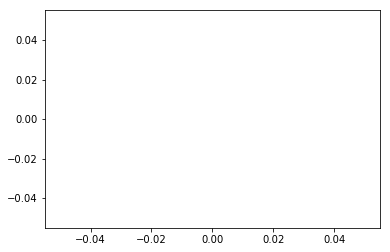

[]


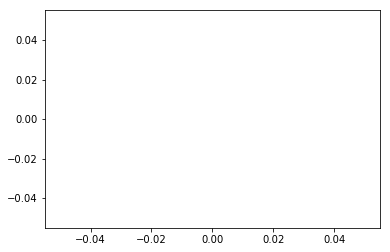

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable co


kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variabl


kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variabl


kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variabl


kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variabl


kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variable containing:
nan
nan
nan
nan
[torch.FloatTensor of size 4]

mse
Variable containing:
nan nan nan nan
nan nan nan nan
nan nan nan nan
nan nan nan nan
[torch.FloatTensor of size 4x4]

kl_div
Variabl

KeyboardInterrupt: 

In [65]:
lr = 1e-4  # 1e-4 for selu
batch_size = 64
EPOCHS = 50
optimizer = t.optim.Adam(f.parameters(), lr=lr, weight_decay=1e-3)
train_losses = []
test_losses = []
PLOT = 500


for _ in range(EPOCHS):
    print('epoch', _)
    
    # shuffle
    x_hand_train, x_board_train, y_hs_train, y_probas_combi_train = shuffle(x_hand_train, x_board_train, y_hs_train, y_probas_combi_train)
    
    # check if weights are NaN
    for p in f.parameters():
        if np.isnan(p.data.numpy()).sum()>0:
            raise ValueError('nan weights !')
    
    for i in range(0, len(train_dataset), batch_size):
        # check if BN var is NaN
#         check_bn_var_nan(f)
        
        # sample batch
        hand = variable(x_hand_train[i:i+batch_size])
        board = variable(x_board_train[i:i+batch_size])
        target_HS = variable(y_hs_train[i:i+batch_size])
        target_probas = variable(y_probas_combi_train[i:i+batch_size])
        if len(hand) != batch_size:
            break
        
        # init grad
        optimizer.zero_grad()
        
        # pred
        HS, probas = f.forward(hand, board)
        HS = clip(HS.squeeze())
        pred_HS = t.log(HS/(1-HS)).squeeze()
        mse = (target_HS - pred_HS)**2  # target already has this format (scaled logit)
        kl_div = t.sum(target_probas[target_probas>0]*t.log(target_probas[target_probas>0]/probas[target_probas>0]), -1)  # KL divergence between target distribution and predicted distribution
        loss = mse + kl_div
#         weights = inv_freq(target, count, bins)  # give more importance to rare samples
#         loss = loss * weights
        
        loss = t.sum(loss)
        train_losses.append(loss.data.numpy()[0]/batch_size)
        
        loss.backward()
#         clip_gradients(f, 5)
        
        optimizer.step()
        
        if (i//batch_size) % PLOT == 0:
            display.clear_output(wait=True)
            print('epoch', _)
            
            # test loss on a random test sample
            x_hand_test, x_board_test, y_hs_test, y_probas_combi_test = shuffle(x_hand_test, x_board_test, y_hs_test, y_probas_combi_test)
            hand = variable(x_hand_test[:1000])
            board = variable(x_board_test[:1000])
            target_hs = variable(y_hs_test[:1000]).squeeze()
            target_probas = variable(y_probas_combi_test[:1000]).squeeze()
            
            f.eval()
            HS, probas = f.forward(hand, board)
            HS = clip(HS)
            f.train()
            
            pred_hs = t.log(HS/(1-HS))
            mse = (target_hs - pred_hs)**2
            kl_div = t.sum(target_probas*((target_probas>0).float())*t.log(target_probas/probas), -1)
            loss = t.sum(mse+kl_div)      
            test_losses.append(loss.data.numpy()[0]/1000)
            
            # plot
            print(test_losses[-10:])
            plt.plot(test_losses)
            plt.show()
            train_losses_ = moving_avg(train_losses)
            print(train_losses_[-10:])
            plt.plot(train_losses_)
            plt.show()

# Test of the model

In [86]:
IDX_TO_RANK = {k:v for k,v in enumerate(Card.RANKS)}
IDX_TO_SUIT = {k:v for k,v in enumerate(Card.SUITS)}

def array_to_card(array):
    if isinstance(array, t.autograd.Variable):
        array_ = array.data.numpy()
    else:
        array_ = array
    cards = []
    for i in range(13):
        for j in range(4):
            if array_[i][j] == 1:
                cards.append(Card(IDX_TO_RANK[i], IDX_TO_SUIT[j]))
    return cards


In [87]:
def c(r, s):
    return Card(r, s)

Test with very small variations. The output of the model should be almost constant here

In [88]:
f.eval()

CardFeaturizer1 (
  (conv1): Conv1d(2, 10, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(10, 10, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(10, 10, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (conv5): Conv1d(2, 10, kernel_size=(1,), stride=(1,))
  (fc1): Linear (390 -> 50)
  (fc2): Linear (26 -> 50)
  (fc3): Linear (50 -> 50)
  (fc4): Linear (40 -> 50)
  (fc5): Linear (52 -> 50)
  (fc6): Linear (50 -> 50)
  (fc7): Linear (52 -> 50)
  (fc8): Linear (50 -> 50)
  (fc9): Linear (52 -> 50)
  (fc10): Linear (50 -> 50)
  (fc11): Linear (150 -> 50)
  (fc12): Linear (52 -> 50)
  (fc13): Linear (50 -> 50)
  (fc14): Linear (250 -> 50)
  (fc15): Linear (50 -> 50)
  (fc18): Linear (50 -> 1)
)

In [89]:
hand = variable(cards_to_array([c('Q','s'), c('K', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board2 = variable(cards_to_array([c('3','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board3 = variable(cards_to_array([c('4','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board4 = variable(cards_to_array([c('2','s'),c('7','h'),c('Q','h')])).resize(1,3,13,4)
board5 = variable(cards_to_array([c('2','c'),c('6','h'),c('Q','h')])).resize(1,3,13,4)
board6 = variable(cards_to_array([c('2','d'),c('3','h'),c('Q','h')])).resize(1,3,13,4)
print(f(hand,board1).data.numpy()[0], f(hand,board2).data.numpy()[0], f(hand,board3).data.numpy()[0], f(hand,board4).data.numpy()[0], f(hand,board5).data.numpy()[0], f(hand,board6).data.numpy()[0])

[ 0.78049672] [ 0.77166033] [ 0.76821387] [ 0.78197074] [ 0.78966945] [ 0.78649539]


Look at the difference of representations

In [95]:
t.sum((f(hand,board1,True)[1] - f(hand,board6,True)[1])**2)

Variable containing:
1.00000e-02 *
  1.1198
[torch.FloatTensor of size 1]

Look at other similar situations. They should have similar representations

In [96]:
hand1 = variable(cards_to_array([c('Q','s'), c('Q', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('5','c'),c('5','h'),c('Q','c')])).resize(1,3,13,4)

hand2 = variable(cards_to_array([c('10','s'), c('10', 'h')])).resize(1,13,4)
board2 = variable(cards_to_array([c('10','c'),c('3','h'),c('3','c')])).resize(1,3,13,4)


In [97]:
t.sum((f(hand1,board1,True)[1] - f(hand2,board2,True)[1])**2)

Variable containing:
 6.4606
[torch.FloatTensor of size 1]

In [98]:
f(hand1,board1), f(hand2, board2)

(Variable containing:
  0.9279
 [torch.FloatTensor of size 1x1], Variable containing:
  0.9178
 [torch.FloatTensor of size 1x1])

Look at some predictions VS true value

In [109]:
def sigmoid(x):
    return (1+np.exp(-x))**(-1)

In [110]:
hand = variable(x_hand_train[i:i+batch_size])
board = variable(x_board_train[i:i+batch_size])
target = sigmoid(scaler.inverse_transform(y_hs_train[i:i+batch_size]))

In [111]:
pred = f.forward(hand,board).squeeze()
for i in range(64):
    print(array_to_card(hand[i]), array_to_card(t.sum(board[i],0)), target[i], pred[i].data.numpy()[0])

[5c, 6c] [2c, 6s, Jc, Kc] 0.934782608696 0.943851
[5d, 6s] [3d, 5h, As] 0.548566142461 0.624475
[4s, 6h] [8s, 10h, As] 0.169287696577 0.264958
[3d, 6d] [3h, 8h, Qs] 0.479185938945 0.589993
[9d, Qs] [5s, 7s, 8s, Kh] 0.413043478261 0.485349
[6c, 8d] [4h, 9d, Jc] 0.245143385754 0.337055
[Kd, As] [7s, 8s, 9c] 0.421831637373 0.524638
[8s, 10d] [2h, 5h, 8h, As] 0.630434782609 0.619393
[5d, Qh] [2s, 3h, Ks] 0.366327474561 0.441952
[7d, 9d] [4d, Qs, Kc] 0.27382053654 0.366679
[3d, 10d] [9d, Kh, Ad] 0.515263644773 0.612026
[4d, 6s] [3c, 5h, 6d] 0.661424606846 0.635482
[Qs, Kh] [7d, 8c, 10s] 0.382053654024 0.500195
[2h, 6c] [4c, 10c, Kc] 0.345050878816 0.463219
[2c, 6h] [2d, 4h, 8c, 8d] 0.434782608696 0.623181
[Qh, Ks] [6h, 7c, 9h] 0.382053654024 0.491199
[5h, 8s] [6h, 7d, Ad] 0.40795559667 0.492166
[9s, Ks] [4d, 8s, Kh, Kc] 0.934782608696 0.865581
[4s, Qs] [8d, Jc, Js, Ad] 0.347826086957 0.459719
[6d, Ac] [4s, 7c, Kd] 0.448658649399 0.510593
[4h, 10d] [5h, 5d, 10s] 0.671600370028 0.772037
[4d, 

In [97]:
hand1 = variable(cards_to_array([c('10','h'), c('J', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('5','h'),c('Q','h'),c('K','c')])).resize(1,3,13,4)

hand2 = variable(cards_to_array([c('5','h'), c('6', 'h')])).resize(1,13,4)
board2 = variable(cards_to_array([c('7','h'),c('8','h'),c('3','c')])).resize(1,3,13,4)


In [98]:
t.sum((f(hand1,board1,True)[1] - f(hand2,board2,True)[1])**2)

Variable containing:
 0.2729
[torch.FloatTensor of size 1]